In [19]:
import os
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [20]:

import os
import tensorflow as tf
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Download dataset using API
dataset_root = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

# 2. Set paths to both subfolders
original_path = os.path.join(dataset_root, "OriginalDataset")
augmented_path = os.path.join(dataset_root, "AugmentedAlzheimerDataset")

# 3. Create a list of file paths and labels from both directories
def collect_image_paths_and_labels(base_path):
    filepaths = []
    labels = []
    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):  # Ensure it's a folder
            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                    filepaths.append(os.path.join(class_path, fname))
                    labels.append(class_name)
    return filepaths, labels

# 4. Combine both Original and Augmented datasets
orig_paths, orig_labels = collect_image_paths_and_labels(original_path)
aug_paths, aug_labels = collect_image_paths_and_labels(augmented_path)

all_paths = orig_paths + aug_paths
all_labels = orig_labels + aug_labels

# 5. Create DataFrame (like ideal code)
df = pd.DataFrame({
    "filepaths": all_paths,
    "labels": all_labels
})

print("Total Images:", len(df))
print("Classes:")
print(df["labels"].value_counts())

Total Images: 40384
Classes:
labels
NonDemented         12800
VeryMildDemented    11200
MildDemented         9856
ModerateDemented     6528
Name: count, dtype: int64


In [21]:
df.shape

(40384, 2)

In [22]:

from sklearn.model_selection import train_test_split

# Train + Val - Test (30% of all data)
trainval_df, test_df = train_test_split(df, test_size=0.3, random_state= 10, stratify=df["labels"])

# Now split trainval into training and validation (20% of trainval → validation)
train_df, val_df = train_test_split(trainval_df, test_size=0.2, random_state= 10, stratify=trainval_df["labels"])

What is flow_from_dataframe()?

Takes a pandas DataFrame where: What we have now



* One column has full image File Paths
* Another has the labels

Its then able to

*   Loads the image from disk (Memory Efficient)
*   Applies resizing, augmentation, preprocessing, etc.
*   Batches them automatically for training
*   Assigns labels based on the column you specify

🗂 DataFrame (paths + labels) → 🍽️ Batches of preprocessed images ready for the model

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Use built-in preprocessing from MobileNetV2 (scale images to expected range)
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [24]:
target_size = (224, 224)
batch_size = 32

train = image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

Found 22614 validated image filenames belonging to 4 classes.


In [25]:
val = image_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 5654 validated image filenames belonging to 4 classes.


In [26]:
test = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=target_size,
    color_mode='rgb',
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 12116 validated image filenames belonging to 4 classes.


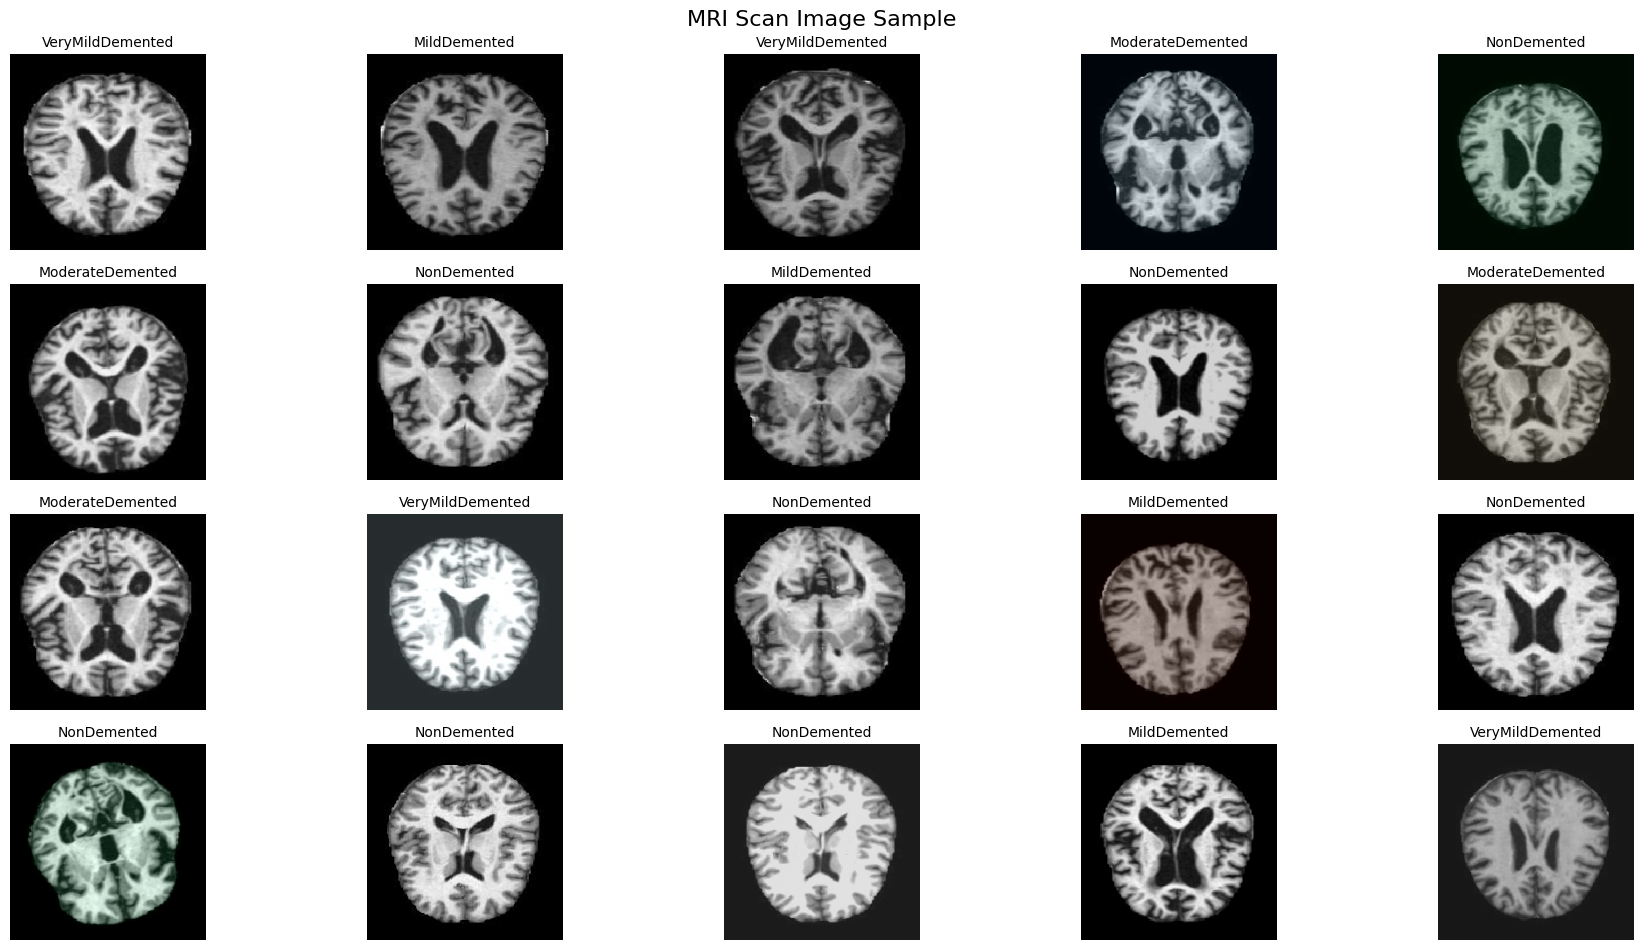

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_images(generator, title="MRI Scan Image Sample"):
    class_indices = generator.class_indices
    classes = list(class_indices.keys())

    # Fetch one batch of images and labels
    images, labels = next(generator)

    plt.figure(figsize=(18, 12))
    num_images = min(20, len(images))

    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # normalization ([-1,1] → [0,1])
        plt.imshow(image)
        label_index = np.argmax(labels[i])
        class_name = classes[label_index]
        plt.title(class_name, fontsize=10)
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 25 images from the training generator
show_sample_images(train)

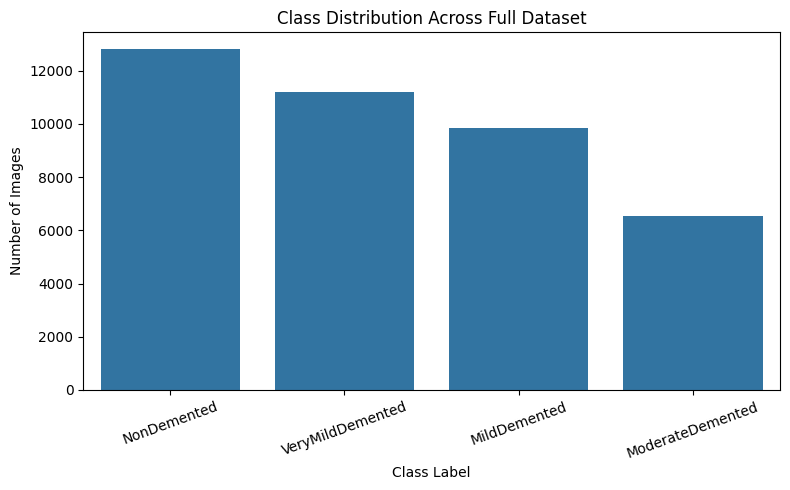

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="labels", order=df["labels"].value_counts().index)
plt.title("Class Distribution Across Full Dataset")
plt.xticks(rotation=20)
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


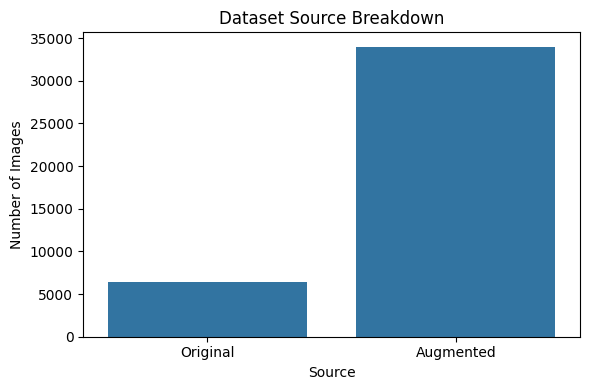

In [29]:
def get_source(filepath):
    if "OriginalDataset" in filepath:
        return "Original"
    elif "AugmentedAlzheimerDataset" in filepath:
        return "Augmented"
    else:
        return "Unknown"

df["source"] = df["filepaths"].apply(get_source)

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="source")
plt.title("Dataset Source Breakdown")
plt.xlabel("Source")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

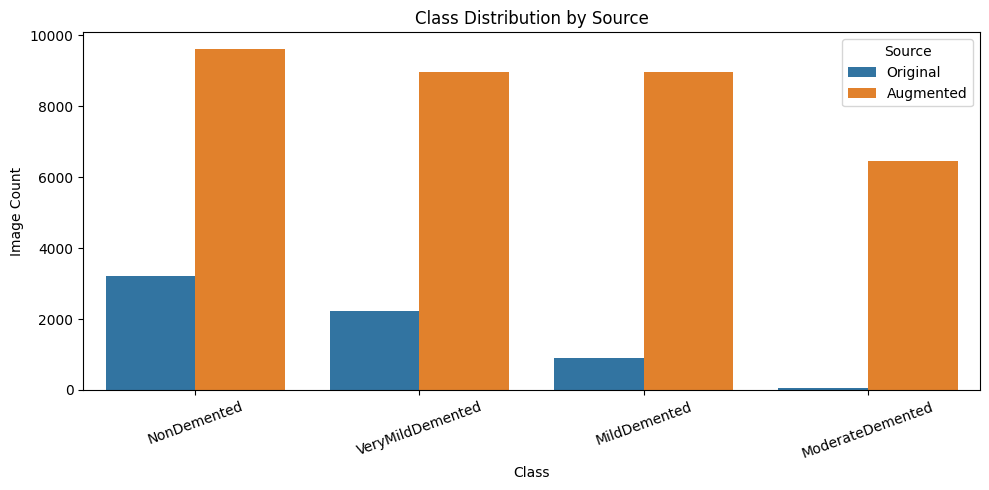

In [30]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="labels", hue="source", order=df["labels"].value_counts().index)
plt.title("Class Distribution by Source")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=20)
plt.legend(title="Source")
plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Block 1
    layers.Conv2D(128, (8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),

    # Block 2
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 6
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Classification head
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 output classes
])

In [32]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [33]:

from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=3,               # Stop if it doesn't improve for 3 epochs
    restore_best_weights=True,  # Go back to the best model (not last epoch)
    verbose=1
)


In [ ]:
import time

# Start the timer
start_time = time.time()

# Train the model
history = model.fit(
    train,
    epochs=40,
    validation_data=val,
    callbacks=[early_stop],
    verbose=1
)

# End the timer
end_time = time.time()

# Calculate duration
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ({training_time / 60:.2f} minutes)")

Epoch 1/40


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

<Figure size 800x500 with 0 Axes>

In [12]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


NameError: name 'history' is not defined

In [13]:
test_loss, test_accuracy = model.evaluate(test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

NameError: name 'model' is not defined

In [14]:
import numpy as np

# Get class indices (e.g., {'Mild Demented': 0, ...})
class_indices = test.class_indices
class_names = list(class_indices.keys())

# Reverse the mapping: 0 → 'Mild Demented', etc.
index_to_class = {v: k for k, v in class_indices.items()}

# Predict
pred_probs = model.predict(test)
pred_labels = np.argmax(pred_probs, axis=1)
pred_class_names = [index_to_class[i] for i in pred_labels]

NameError: name 'model' is not defined

In [15]:
true_labels = test.classes  # Numeric form
true_class_names = [index_to_class[i] for i in true_labels]

In [17]:
from sklearn.metrics import classification_report

print(classification_report(true_class_names, pred_class_names, target_names=class_names))

NameError: name 'pred_class_names' is not defined

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_class_names, pred_class_names, labels=class_names)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

NameError: name 'pred_class_names' is not defined